In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
data = pd.read_csv('data.csv',index_col=0)
data = data.set_index(data.timestamp)
data.head()


,address,x,y,z,timestamp
timestamp,,,,,
2018-07-01 00:55:41.678,-6196490120761152012,-47.9602,-59.9457,6.24468,2018-07-01 00:55:41.678
2018-07-01 00:55:42.923,-6196490120761152012,-46.4965,-60.0888,6.25606,2018-07-01 00:55:42.923
2018-07-01 00:55:44.163,-6196490120761152012,-45.1626,-60.3775,6.46899,2018-07-01 00:55:44.163
2018-07-01 00:55:45.412,-6196490120761152012,-44.1827,-60.4705,6.57457,2018-07-01 00:55:45.412
2018-07-01 00:55:46.704,-6196490120761152012,-43.9995,-60.4705,6.58655,2018-07-01 00:55:46.704


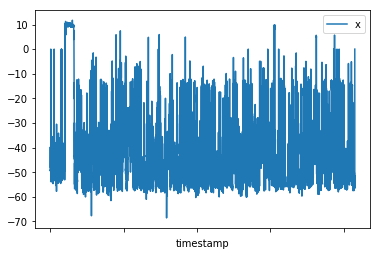

In [4]:
data.plot(x='timestamp', y='x')

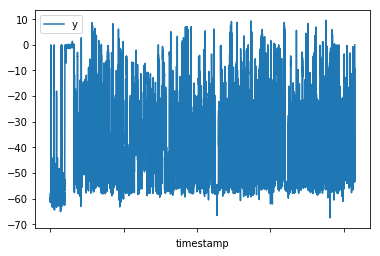

In [5]:
data.plot(x='timestamp',y='y')

In [6]:
len(data)

207689

In [7]:
### Convert the data into arrays and remve the first column and the last column from the array which add no informations

data_arr = data.values
data_arr= data_arr[:,1:]
data_arr = data_arr[:,:-1:]
data_arr[0]

array([-47.9602, -59.9457, 6.2446800000000025], dtype=object)

In [8]:
# Remove zero values 
data = data[(data != 0).all(1)]
print(len(data))

# Remove zero values in axis
x_data = data_arr[(data_arr != 0).all(1)]
y_data = x_data.copy()
x_data[0]

207639


array([-47.9602, -59.9457, 6.2446800000000025], dtype=object)

#### SIZE OF DATA

In [9]:
num_data = len(x_data)
num_data

207639

#### This is the fraction of the data-set that will be used for the training-set:

In [10]:
train_split = 0.9

In [11]:
num_train = int(train_split * num_data)
num_train

186875

In [12]:
num_test = num_data - num_train
num_test

20764

#### Inputs for the training and test sets

In [13]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

207639

#### These are the output-signals for the training- and test-sets:

In [14]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

207639

#### Number of input-signals:

In [15]:
num_x_signals = x_data.shape[1]
num_x_signals

3

##### Number of output-signals:

In [16]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### Scaling data

In [17]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -68.5928
Max: 23.1883


In [18]:
x_scaler = MinMaxScaler()


#### Scale training data

In [19]:
x_train_scaled = x_scaler.fit_transform(x_train)

C:\Users\saran\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


##### Scale test data

In [21]:
x_test_scaled = x_scaler.transform(x_test)

##### Scale target values

In [22]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\saran\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Data Generator

###### Array shapes of Input and output

In [23]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(186875, 3)
(186875, 3)


#### Batch data generator : Batch wise training


In [24]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [25]:
batch_size = 128
sequence_length = 900

#### Initialize batch data generator object

In [26]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

##### Test the generator

In [27]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(128, 900, 3)
(128, 900, 3)


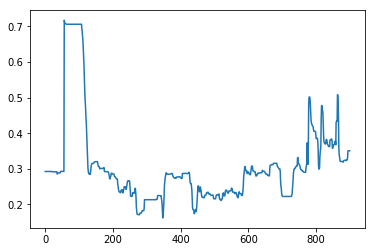

In [28]:
##### Plot the input batch and signal 

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 3 input-signals (X,Y,Z).
seq = x_batch[batch, :, signal]
plt.plot(seq)

##### Plot the target signal

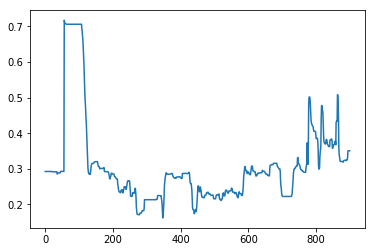

In [29]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation for early stopping

In [30]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

### Recurrent neural network model

In [38]:
model = Sequential()

In [39]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [40]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [41]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [42]:
warmup_steps = 50

In [43]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [44]:
optimizer = RMSprop(lr=1e-3)

In [45]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         792576    
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           1539      
Total params: 794,115
Trainable params: 794,115
Non-trainable params: 0
_________________________________________________________________


In [47]:
path_checkpoint = '24_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [48]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [49]:
callback_tensorboard = TensorBoard(log_dir='./24_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [50]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [51]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### Train the Recurrent Neural Network

In [45]:
%%time

model.fit_generator(generator=generator,
                    epochs=10,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/10
 99/100 [============================>.] - ETA: 5s - loss: 0.0091 
Epoch 00001: val_loss improved from inf to 0.00359, saving model to 24_checkpoint.keras
100/100 [==============================] - 614s 6s/step - loss: 0.0090 - val_loss: 0.0036
Epoch 2/10
 99/100 [============================>.] - ETA: 5s - loss: 0.0027 
Epoch 00002: val_loss improved from 0.00359 to 0.00181, saving model to 24_checkpoint.keras
100/100 [==============================] - 553s 6s/step - loss: 0.0027 - val_loss: 0.0018
Epoch 3/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00181 to 0.00056, saving model to 24_checkpoint.keras
100/100 [==============================] - 202s 2s/step - loss: 0.0015 - val_loss: 5.6490e-04
Epoch 4/10
 99/100 [============================>.] - ETA: 2s - loss: 9.5972e-04
Epoch 00004: val_loss did not improve from 0.00056

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100

In [46]:
### Load the checkpoint weights

In [52]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [53]:
### Performance on test set

In [54]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 15s 15s/step


In [55]:
print("loss (test-set):", result)

loss (test-set): 0.0001535096380393952


In [56]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):   # One one metric 'Loss'
        print("{0}: {1:.3e}".format(metric, res))

### Generate predictions

In [59]:
def plot_comparison(start_idx, length=100, train=False,forecast = False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if forecast:
        x = x_test_scaled.copy()
    
    elif train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    if forecast:
        x = x[start_idx:end_idx]
        
    else:
        x = x[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    pred_dict = {i: None for i in target_names} 
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        pred_dict[target_names[signal] = signal_pred
#         if forecast == False:
#             # Get the true output-signal from the data-set.
#             signal_true = y_true[:, signal]

#         # Make the plotting-canvas bigger.
#         plt.figure(figsize=(15,5))
        
#         if forecast == False:
            
#             # Plot and compare the two signals.
#             plt.plot(signal_true, label='true')
        
#         plt.plot(signal_pred, label='pred')
        
#         # Plot grey box for warmup-period.
#         p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
#         # Plot labels etc.
#         plt.ylabel(target_names[signal])
#         plt.legend()
#         plt.show()

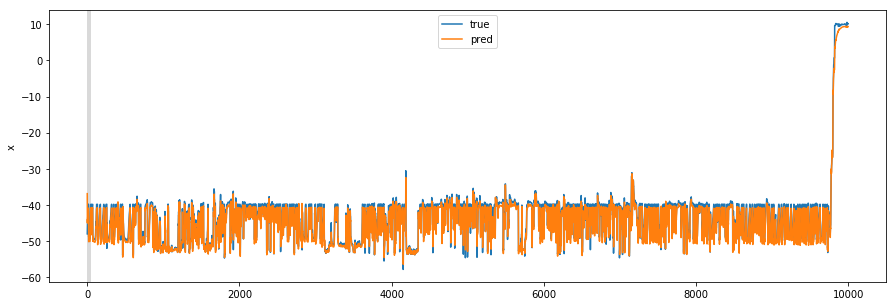

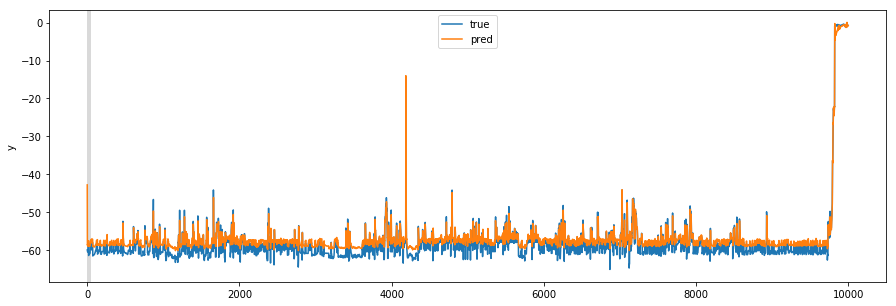

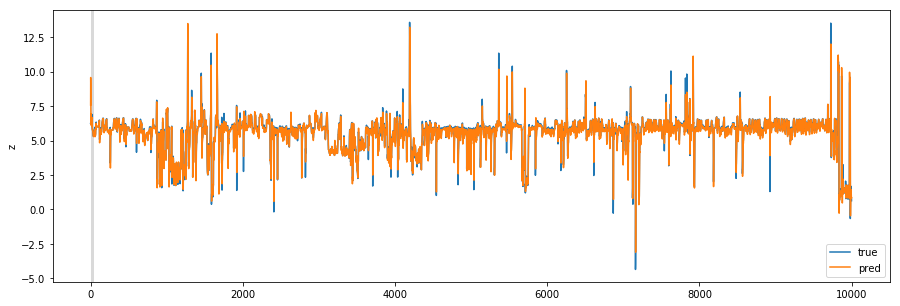

In [62]:
plot_comparison(start_idx=0, length=10000, train=True, forecast = False)

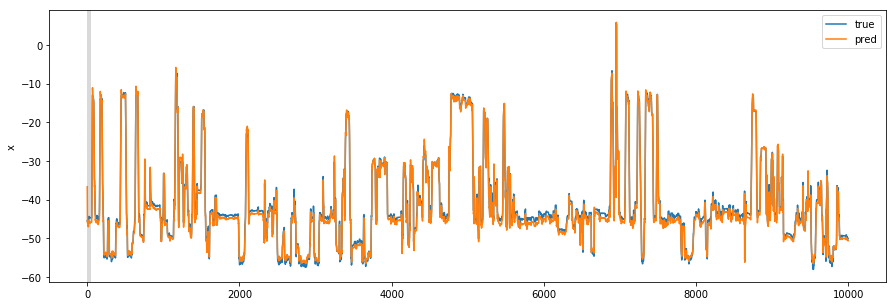

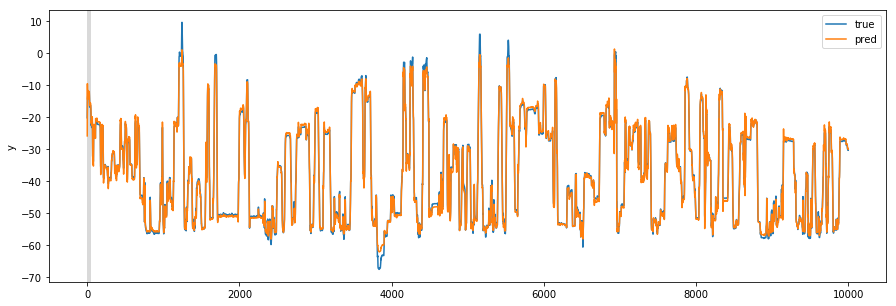

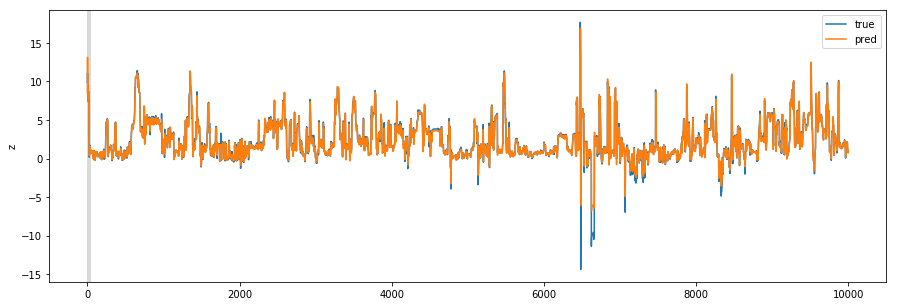

In [63]:
plot_comparison(start_idx=0, length=10000, train=False, forecast = False)

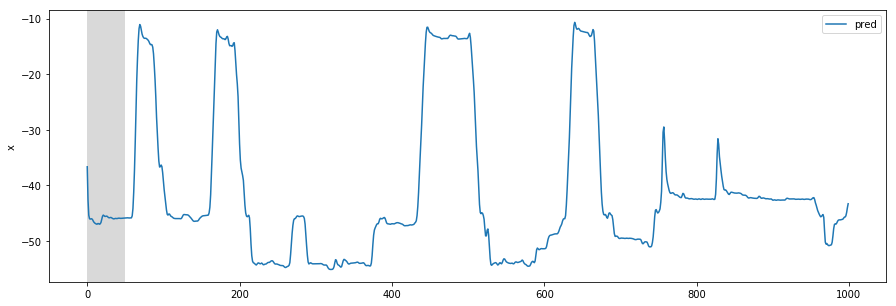

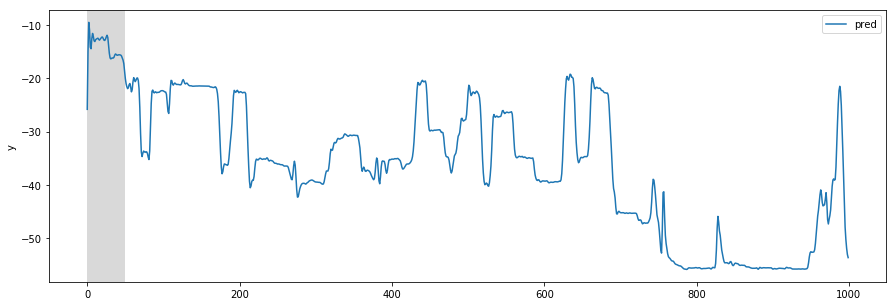

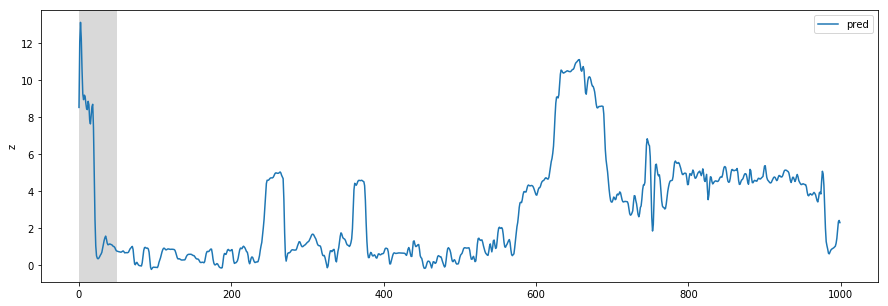

In [64]:
target_names = ['x','y','z']
plot_comparison(start_idx=0, length=1000, train=False,forecast = True)